# Regression Model : Kepler - Orbital Period

#### Import required packages.

In [75]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as sm
import math
from pandas.stats.api import ols
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
import sklearn.model_selection as m_sel
import plotly.offline as plot
import plotly.graph_objs as go
from sklearn import preprocessing
plot.offline.init_notebook_mode(connected=True)

#### Load Data Files.

In [92]:
data = pd.read_csv('./Data/Ex01_Kepler_Regression.csv')

Correlation Matrix

In [83]:
corr = data.corr()
corr

,SemiMajorAxis,Volume,EscapeVelocity,Density,OrbitalPeriod
SemiMajorAxis,1.000000,0.278926,0.323329,-0.716234,0.918149
Volume,0.278926,1.000000,-0.015625,-0.153851,0.229391
EscapeVelocity,0.323329,-0.015625,1.000000,-0.687354,0.225476
Density,-0.716234,-0.153851,-0.687354,1.000000,-0.565611
OrbitalPeriod,0.918149,0.229391,0.225476,-0.565611,1.000000


Correlation Graph.

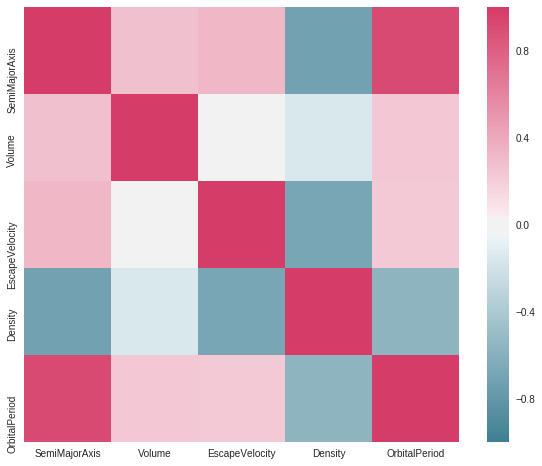

In [84]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 1, as_cmap=True),
            square=True, ax=ax)
plt.show()

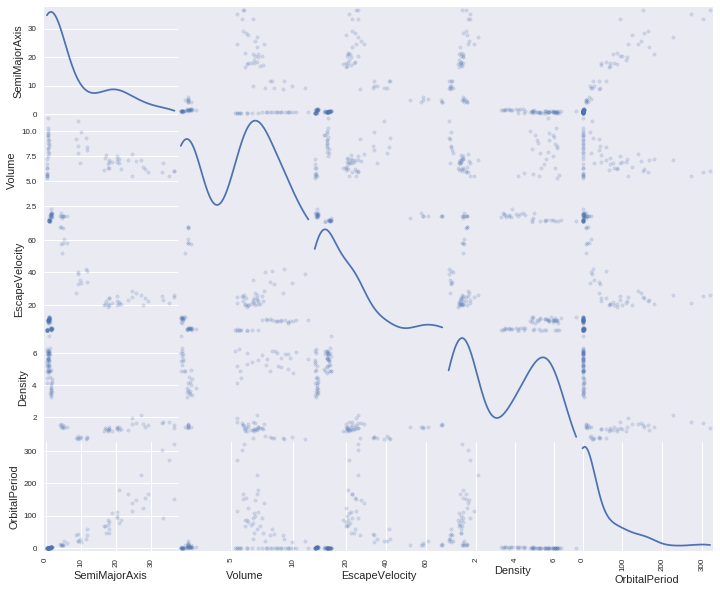

In [85]:
pd.scatter_matrix(data, alpha=.2, figsize=(12,10), diagonal='kde')
plt.show()

Modify Features.

In [93]:
data.drop('planet',axis = 1, inplace=True)
data_mod = data

Test Data and Training data.

In [94]:
data_mod.dtypes

SemiMajorAxis     float64
Volume            float64
EscapeVelocity    float64
Density           float64
OrbitalPeriod     float64
dtype: object

In [95]:
data_mod['SemiMajorAxis'] = data_mod.SemiMajorAxis**1.5
for i in data_mod.columns.tolist():
    data_mod[i] = (data_mod[i] - data_mod[i].mean())/(data_mod[i].var())

In [96]:
X_rl = pd.get_dummies(data_mod).drop('OrbitalPeriod', axis=1)
y_rl = data_mod.OrbitalPeriod
X_train, X_test , Y_train, Y_test = m_sel.train_test_split(X_rl, y_rl, test_size=0.30, random_state=30)

### Linear Regression Model

In [97]:
regr = linear_model.LinearRegression(normalize=True)
regr.fit(X_train, Y_train)
print ('Coefficients : ', regr.coef_) 
print ('\nIntercepts  : ', regr.intercept_)
print ('\nRMSE : ', math.sqrt(np.mean((regr.predict(X_test) - Y_test) ** 2)))

Coefficients :  [  7.96175359e-01  -6.93680688e-04   7.52889484e-05   8.60275957e-04]

Intercepts  :  -0.000259498374736

RMSE :  0.00311721399309256


#### Plots using Plotly.

In [98]:
trace = go.Scatter(
    x=regr.predict(X_test),
    y= Y_test,
    mode='markers',
    name = 'Predicted vs Original',
    line=dict(shape='linear')
)
trace1 = go.Scatter(
    x= Y_test,
    y= Y_test,
    mode='lines',
    name = 'x = y',
    line=dict(shape='linear')
)
data = [trace, trace1]
layout = dict(
    legend=dict(
        traceorder='reversed',
        font=dict(size=16)
    )
)
fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='Scatter plot for Normal Regression')


#### Histogram plot.

In [99]:
data = [go.Histogram(x=((regr.predict(X_test) - Y_test)))]
layout = go.Layout(
    title='Frequency Of Residuals',
    xaxis=dict(
        title='Residuals'
    ),
    yaxis=dict(
        title='Frequency'
    )
)
fig = go.Figure(data=data, layout=layout)
plot.iplot(fig, filename='normalized histogram')

In [100]:
trace0 = go.Box(
    y = (regr.predict(X_test) - Y_test)
)

data = [trace0]

plot.iplot(data)

## RIDGE

In [101]:
alphas = np.logspace(-3,1,200)

In [102]:
ridge = linear_model.Ridge(normalize=True)
coefs = []
mean_errors = []

comn_name1 = X_train.columns.tolist()
comn_name = comn_name1
comn_name.append('alpha')
df = pd.DataFrame(index=list(range(len(alphas))),columns=comn_name)
s = 0

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train,Y_train)
    coefs.append(ridge.coef_)
    pred = ridge.predict(X_test) 
    mean_errors.append(mean_squared_error(Y_test, pred))
    k=0
    while (k < len(comn_name)-1):
        df.loc[s,list(df.columns)[k]] = ridge.coef_[k]
        k = k+1
    df.loc[s,'alpha'] =a    
    s=s+1

In [103]:
comn_name1.pop()

'alpha'

In [104]:
data = []
for i in comn_name1:
    p = go.Scatter(x= df.alpha, y= df.loc[:,i].tolist(), mode='lines+markers', name=i, hoverinfo='name', line=dict(shape='linear'))
    data.append(p)
        
layout = dict(
    legend=dict(
        
        traceorder='reversed',
        font=dict(size=16)
    )
)
fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='MPG - RIDGE')

In [105]:
data = []
p = go.Scatter(x= alphas, y=mean_errors, mode='lines+markers', name='Mean Error', hoverinfo='name', line=dict(shape='linear'))
data.append(p)        
layout = dict(
    legend=dict(
        
        traceorder='reversed',
        font=dict(size=16)
    )
)
fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='MPG - MEAN ERROR')








## LASSO

In [106]:
lasso = linear_model.Lasso(max_iter=10000, normalize=True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit((X_train), Y_train)
    coefs.append(lasso.coef_)

In [107]:
coefs = np.array(coefs)
np.shape(coefs)

(200, 4)

In [108]:
data = []
for beta in range(len(X_train.columns)):
    trace = go.Scatter(
        x = alphas,
        y = coefs[:,beta],
        mode='lines+markers',
        name = X_train.columns[beta],
        line=dict(shape='linear')
    )
    data.append(trace)


# Edit the layout
layout = dict(
    yaxis = dict(
        range = [-0.01,.1],
    ),
    xaxis = dict(
        range = [0,.005]
    ),
    legend=dict(
        traceorder='reversed',
        font=dict(size=16)
    ))

fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='weight-alpha-lasso')

In [109]:
lassocv = linear_model.LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, Y_train)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)
mean_squared_error(Y_test, lasso.predict(X_test))

1.010834635871844e-05

In [110]:
pd.Series(lasso.coef_, index=X_test.columns)

SemiMajorAxis     0.757095
Volume           -0.000000
EscapeVelocity   -0.000000
Density          -0.000000
dtype: float64

## OLS - REGRESSION

In [111]:
ols_result = sm.ols(formula="OrbitalPeriod ~ SemiMajorAxis ", data = data_mod.iloc[:math.floor(len(data_mod)*0.70),:]).fit()
ols_result.params
predict_ols = ols_result.predict(X_test)

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          OrbitalPeriod   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     399.7
Date:                Fri, 31 Mar 2017   Prob (F-statistic):           3.50e-30
Time:                        20:55:08   Log-Likelihood:                 263.28
No. Observations:                  70   AIC:                            -522.6
Df Residuals:                      68   BIC:                            -518.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0002      0.001     -0.343      0.732      -0.002       0.001
SemiMajorAxis     0.7625      0.038     19.992      0.000       0.686       0.839
==============================================================================
Omnibus:                       19.899   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.494
Skew:                          -0.219   Prob(JB):                     1.70e-29
Kurtosis:                       9.726   Cond. No.                         55.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
trace = go.Scatter(
    x=predict_ols,
    y= Y_test,
    mode='markers',
    name = 'Predicted vs Original',
    line=dict(shape='linear')
)
trace1 = go.Scatter(
    x= Y_test,
    y= Y_test,
    mode='lines',
    name = 'x = y',
    line=dict(shape='linear')
)
data = [trace, trace1]
layout = dict(
    legend=dict(
        traceorder='reversed',
        font=dict(size=16)
    )
)
fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='Scatter plot for Normal Regression')


## HISTOGRAM

In [113]:
data = [go.Histogram(x=((predict_ols - Y_test)))]
layout = go.Layout(
    title='Frequency Of Residuals',
    xaxis=dict(
        title='Residuals'
    ),
    yaxis=dict(
        title='Frequency'
    )
)
fig = go.Figure(data=data, layout=layout)
plot.iplot(fig, filename='normalized histogram')

### BOXPLOT

In [114]:
trace0 = go.Box(
    x = (predict_ols - Y_test)
)

data = [trace0]

plot.iplot(data)